In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pickle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths for dataset and outputs
dataset_path = '/content/drive/My Drive/dataset/'  # Adjust this path as per your data location
output_path = '/content/drive/My Drive/'  # Adjust this path for saving models/pickles


Mounted at /content/drive


In [ ]:


IMG_SIZE = 128  # Target image size for resizing
haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'  # Haar cascade path

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Prepare dataset
categories = os.listdir(dataset_path)  # Class names are the folder names
print("Categories:", categories)

data = []
labels = []

# Process each category folder
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        try:
            img_path = os.path.join(folder_path, img_name)
            img_array = cv2.imread(img_path)  # Load image
            if img_array is None:
                print(f"Failed to load {img_path}")
                continue

            # Convert to grayscale for face detection
            gray_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

            # Crop the first detected face (if any)
            if len(faces) > 0:
                x, y, w, h = faces[0]  # Taking the first detected face
                face = img_array[y:y + h, x:x + w]
                face = cv2.resize(face, (IMG_SIZE, IMG_SIZE))  # Resize to target size
                data.append(face)
                labels.append(category)  # Label as folder name
            else:
                print(f"No face detected in {img_path}")
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Convert to numpy arrays
data = np.array(data, dtype=np.float32) / 255.0  # Normalize pixel values
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Save category mapping for later use
category_names = {i: cat for i, cat in enumerate(le.classes_)}
with open("categories.pkl", "wb") as file:
    pickle.dump(category_names, file)
print("Category mapping saved:", category_names)




Categories: ['Faysal', 'Tareq', 'Tanzil', 'Mohim']
No face detected in /content/drive/My Drive/dataset/Faysal/Faysal (161).jpg
No face detected in /content/drive/My Drive/dataset/Faysal/Faysal (158).jpg
No face detected in /content/drive/My Drive/dataset/Faysal/Faysal (159).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (97).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (96).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (71).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (94).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (103).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (57).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (93).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (56).jpg
No face detected in /content/drive/My Drive/dataset/Tareq/Tareq) (43).jpg
No face detected in /content/drive/My Drive/dataset/Ta

In [ ]:
import random
import matplotlib.pyplot as plt

# Select 20 random indices from the dataset
random_indices = random.sample(range(len(data)), 20)

# Plot the images with their labels
plt.figure(figsize=(15, 10))

for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.imshow(data[idx])  # Display the image
    plt.title(f" {category_names[labels[idx]]}")  # Show the label
    plt.axis('off')  # Turn off axes for better visualization

plt.tight_layout()
plt.show()


In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))

# Print dataset shapes
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (422, 128, 128, 3)
Validation data shape: (106, 128, 128, 3)
Training labels shape: (422, 4)
Validation labels shape: (106, 4)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the path to save the best model
best_model_path = "/content/drive/MyDrive/face_recognition_model.keras"

# Create callbacks
checkpoint = ModelCheckpoint(
    filepath=best_model_path,          # Path to save the best model
    monitor='val_loss',                # Metric to monitor
    save_best_only=True,               # Save only the model with the best val_loss
    save_weights_only=False,           # Save the entire model (not just weights)
    verbose=1                          # Print update messages
)

early_stopping = EarlyStopping(
    monitor='val_loss',                # Metric to monitor
    patience=3,                        # Stop after 3 epochs of no improvement
    restore_best_weights=True,         # Restore model weights from the best epoch
    verbose=1                          # Print early stopping message
)

# Train the model with callbacks
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16,
    callbacks=[checkpoint, early_stopping]  # Add callbacks here
)







Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.4543 - loss: 1.3505
Epoch 1: val_loss improved from inf to 0.51264, saving model to /content/drive/MyDrive/face_recognition_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 697ms/step - accuracy: 0.4602 - loss: 1.3368 - val_accuracy: 0.8302 - val_loss: 0.5126
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.8925 - loss: 0.3885
Epoch 2: val_loss improved from 0.51264 to 0.20018, saving model to /content/drive/MyDrive/face_recognition_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 23s 799ms/step - accuracy: 0.8928 - loss: 0.3862 - val_accuracy: 0.9340 - val_loss: 0.2002
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9389 - loss: 0.1666
Epoch 3: val_loss improved from 0.20018 to 0.09484, saving model to /content/drive/MyDrive/face_recognition_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 38s 690ms/step - accuracy: 0.9392 - loss: 0.1662 - val_accuracy: 0.9528 - val_loss: 0.0948
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━

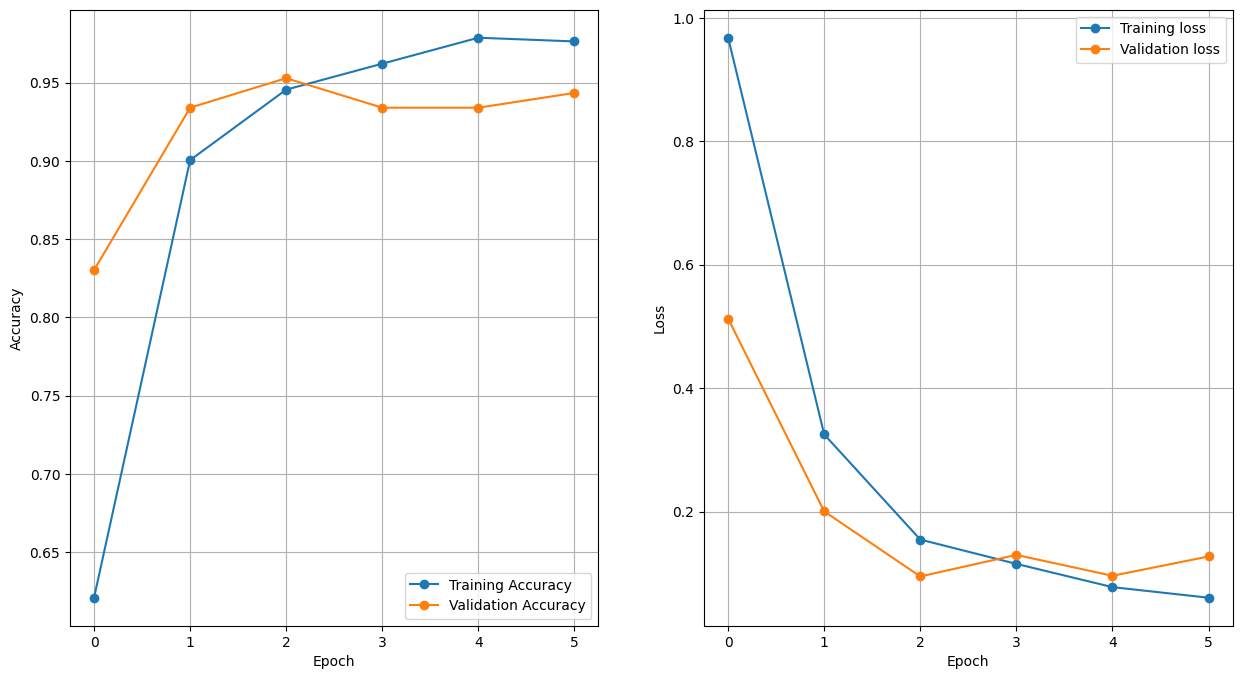

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], 'o-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'o-', label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'o-', label='Training loss')
plt.plot(history.history['val_loss'], 'o-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()


In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       7,372,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,233,038 (84.81 MB)

 Trainable params: 7,411,012 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,822,026 (56.54 MB)

In [ ]:
# Save label encoder, images, and category names
with open(os.path.join(output_path, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)


with open(os.path.join(output_path, 'data.pkl'), 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_val': X_val, 'y_train': y_train, 'y_val': y_val}, f)


In [ ]:
import logging

# Suppress TensorFlow warnings about saving in HDF5 format
logging.getLogger('absl').setLevel(logging.ERROR)

# Save the model in HDF5 format
model_path = os.path.join(output_path, 'model.h5')
model.save(model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/My Drive/model.h5


In [ ]:
with open("/content/drive/My Drive/categories.pkl", "wb") as file:
    pickle.dump(category_names, file)
print("Category mapping saved:", category_names)

Category mapping saved: {0: 'Faysal', 1: 'Mohim', 2: 'Tanzil', 3: 'Tareq'}


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle

# Load the saved model
model = load_model('/content/drive/MyDrive/face_recognition_model.keras')

# Load the label encoder or class labels
with open('/content/drive/MyDrive/categories.pkl', 'rb') as f:
    class_labels = pickle.load(f)

# Haar cascade path for face detection
haarcascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haarcascade_path)

# Function to preprocess the face
def preprocess_face(face, target_shape):
    normalized_face = cv2.resize(face, (target_shape[1], target_shape[2])) / 255.0
    face_array = np.expand_dims(normalized_face, axis=0)
    return face_array

# Function to recognize and display the result
def recognize_image_with_haarcascade(image_path, confidence_threshold=0.7):
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Convert the image to grayscale for Haar cascade
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No face detected.")
        return

    # Process the first detected face
    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]  # Crop the detected face

    # Preprocess the face
    face_array = preprocess_face(face, model.input_shape)

    # Predict the label
    predictions = model.predict(face_array, verbose=0)
    confidence = np.max(predictions)
    label_index = np.argmax(predictions)
    label = class_labels[label_index] if confidence >= confidence_threshold else "Unknown"

    # Display the result
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(
        img,
        f"{label} ({confidence*100:.2f}%)",
        (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 0, 0),
        2,
    )

    # Display the image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f" {label} --->{confidence*100:.2f}%")
    plt.show()

# Path to the image you want to recognize
image_path = '/content/drive/MyDrive/test/tanzil/WIN_20241129_19_27_06_Pro.jpg'  # Update this to your image path

# Recognize the image using Haar cascade
recognize_image_with_haarcascade(image_path, confidence_threshold=0.85)
